# Importação das bibliotecas necessárias

In [106]:
import autosklearn.classification
import joblib
import datetime
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport
from unidecode import unidecode

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split


import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve
from skopt import BayesSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import lime
import lime.lime_tabular

# Criação de dataset

In [107]:
df = pd.read_feather('../data/carteira_total.feather')


In [108]:
df.head(3)

mÊs    ID CRM  ID NAVPLAT      ID SAP REGIÃO      CIDADE      BAIRRO  \
0 2020-01-01  10400005    10400005  2000340391     DF  SOBRADINHO  Sobradinho   
1 2020-01-01  10400007    10400007  2000340644     DF    BRASÍLIA     Asa Sul   
2 2020-01-01  10400014    10400014  2000254856     DF    BRASÍLIA     Asa Sul   

   VALOR MENSAL  VALOR HOJE UPSALE/DOWNSALE  ...  LEADS FORM LEADS VER DATO  \
0         434.4       434.4              ok  ...        21.0          100.0   
1         312.0       312.0              ok  ...        18.0          106.0   
2        1798.8      1798.8              ok  ...       174.0          520.0   

  LEADS TOTAL Custo por lead total  Total Contratado  TOTAL DE LISTINGS  \
0       121.0             3.590083              50.0                  9   
1       124.0             2.516129              25.0                  7   
2       694.0             2.591931           10031.0                 67   

   CUSTO POR LISTING  PF/PJ  Total Utilizado  Faixa Listings  
0          48.266667     PJ              9.0          6 – 10  
1          44.571429     PF              7.0          6 – 10  
2          26.847761     PJ             67.0        61 – 100  

[3 rows x 36 columns]

# Pandas Proffling

In [109]:
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

In [110]:
# Missing Values
# contratado_freemium (52.1%) - Quantidade de zeros (25.9%)
# utilizado_freemium (52.1%) - Quantidade de zeros (44.5%)

# possui_midia_ativa_ (0.6%) - categorica
# custo_por_lead_total (0.4%)
# total_contratado (0.4%)
# utilizado_super_destaques (< 0.1%)
# utilizado_destaque (< 0.1%)
# utilizado_ofertas_simples (< 0.1%)
# leads_form (< 0.1%)
# leads_ver_dato (< 0.1%)
# leads_total (< 0.1%)
# custo_por_listing (< 0.1%)
# total_utilizado (< 0.1%)
# faixa_listings (< 0.1%) - categorica


# EDA

Remoção dos acentos das colunas e alteração dos caracteres diferentes de alfa numérico para "_"

In [111]:
newColumnsName = []
for column_name in df:
  newColumnsName.append(re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName

Criação da coluna churn, e definição do seu valor com base nos valores da coluna upsale_downsale (churn = 1, demais valores = 0). Decidimos excluir a coluna upsell_downsell (por não ter mais importância para a análise)

In [112]:
df["upsale_downsale"].replace({"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace({"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)
df['churn'] = df['churn'].astype(int)

df.drop(columns = ["upsale_downsale"], inplace = True)

In [113]:
df.head(3)

mes    id_crm  id_navplat      id_sap regiao      cidade      bairro  \
0 2020-01-01  10400005    10400005  2000340391     DF  SOBRADINHO  Sobradinho   
1 2020-01-01  10400007    10400007  2000340644     DF    BRASÍLIA     Asa Sul   
2 2020-01-01  10400014    10400014  2000254856     DF    BRASÍLIA     Asa Sul   

   valor_mensal  valor_hoje  faturamento  ... leads_ver_dato leads_total  \
0         434.4       434.4        434.0  ...          100.0       121.0   
1         312.0       312.0        312.0  ...          106.0       124.0   
2        1798.8      1798.8       1799.0  ...          520.0       694.0   

  custo_por_lead_total  total_contratado  total_de_listings  \
0             3.590083              50.0                  9   
1             2.516129              25.0                  7   
2             2.591931           10031.0                 67   

   custo_por_listing  pf_pj  total_utilizado  faixa_listings  churn  
0          48.266667     PJ              9.0          6 – 10      0  
1          44.571429     PF              7.0          6 – 10      0  
2          26.847761     PJ             67.0        61 – 100      0  

[3 rows x 36 columns]

#### Adição da coluna quantidade_mes respectiva a quantidade de meses os ID SAP é cliente

In [114]:
df_grouped = df[['mes', 'id_sap']].groupby(['id_sap']).count().reset_index()

df_grouped.rename(columns = {'mes':'quantidade_mes'}, inplace=True)

In [115]:
df_grouped.sample(2)


id_sap  quantidade_mes
11973  2001023587               7
3217   2000319282               3

In [116]:
df = df.join(df_grouped.set_index('id_sap'), on='id_sap')
    

In [117]:
df.sample(2)

mes    id_crm  id_navplat      id_sap regiao    cidade  \
133463 2021-09-01  47243171    47243172  2000459138     SP      MAUÁ   
100008 2021-04-01  47248151    47248153  2000476275     PR  CURITIBA   

             bairro  valor_mensal  valor_hoje  faturamento  ... leads_total  \
133463  VILA MAGINI        1149.0      1149.0       1149.0  ...       116.0   
100008          nan         309.0       309.0        309.0  ...        78.0   

       custo_por_lead_total total_contratado  total_de_listings  \
133463             9.905172             70.0                157   
100008             3.961538             80.0                 43   

        custo_por_listing  pf_pj  total_utilizado  faixa_listings  churn  \
133463           7.318471     PJ            177.0       101 – 200      0   
100008           7.186047     PJ             51.0         41 – 60      0   

        quantidade_mes  
133463              22  
100008              21  

[2 rows x 37 columns]

#### Definição do quality score de cada registro

In [118]:
xls = pd.ExcelFile('../data/quality_score.xlsx')
xls.sheet_names

i = 0
for data in xls.sheet_names:
    if i == 0:
        dfQuality = pd.read_excel(xls, data)
        dfQuality['data'] = data
        dfQuality.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                  'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)
    else:
        dfQualityAux = pd.read_excel(xls, data)
        dfQualityAux['data'] = data
        dfQualityAux.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                     'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)

        dfQuality = pd.concat([dfQuality, dfQualityAux])

    i+=1

In [119]:
dfQuality['status_pagamento'].unique()


array(['4. Péssimo', '2. Regular ', '1. Bom', '3. Ruim', '5. Novo', 'C2C',
       '2. Regular', '1. Bom ', 'lançamentos', nan, '5. novo', 0],
      dtype=object)

In [120]:
dfQuality['status_pagamento'].replace({'4. Péssimo': 'Pessimo', '2. Regular ': 'Regular', '1. Bom': 'Bom', '3. Ruim': 'Ruim', '5. Novo': 'Novo',
                                       '2. Regular': 'Regular', '1. Bom ': 'Bom', 'lançamentos': np.nan, '5. novo': 'Novo', 0: np.nan}, inplace=True)


In [121]:
dfQuality.head()


ID SAP status_pagamento   data
0  2000252554          Pessimo  out20
1  2000251191          Regular  out20
2  2000251824              Bom  out20
3  2000248936              Bom  out20
4  2000252090              Bom  out20

In [122]:
dfQuality.dropna(inplace=True)

In [123]:
dfQuality['status_pagamento'].isna().sum()


0

In [124]:
regex = r'([0-9]{4})-([0-9]{2})-[0-9]{2}'

def fun_replace(data): 
    return datetime.datetime.strptime(str(data.group(2)).lower(), '%m').strftime('%b').lower() + data.group(1)[-2:]

df['mes'] = df['mes'].astype(str).str.replace(regex, fun_replace, regex=True)


In [125]:
dfQuality.columns


Index(['ID SAP', 'status_pagamento', 'data'], dtype='object')

In [126]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn', 'quantidade_mes'],
      dtype='object')

In [127]:
dfQuality.rename(columns={'ID SAP': 'id_sap', 'data' : 'mes'}, inplace=True)

In [128]:
df = df.join(dfQuality.set_index(['id_sap', 'mes']), on=['id_sap', 'mes'])


## Padronizando valores categóricos

### Oficina

In [129]:
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

In [130]:
df['oficina'].replace({'wi': 'WI'}, inplace=True) # Alterando o valor wi para igualar a WI
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

### Faturamento

In [131]:
df['frequencia_de_faturamento'].unique()

array(['Mensal', 'Anual', 'Semestral', 'Trimestral', 'MENSAL', 'ANUAL',
       'SEMESTRAL', 'TRIMESTRAL', '0'], dtype=object)

In [132]:
#corrigir diferenças de nomes
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

In [133]:
#remover espaços

df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

In [134]:
#renomeando unica vez

df['frequencia_de_faturamento'].replace({'única vez': 'unica_vez'}, inplace=True)
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

### Tipo de Plano

In [135]:
df['tipo_de_plano'].unique()

array(['LIMITADO', 'ILIMITADO', 'nan', 'SIMPLES', 'PACK', '0'],
      dtype=object)

### Midia Ativa

In [136]:
df['possui_midia_ativa_'].unique()

array(['No', 'Si', None], dtype=object)

### PF_PJ

In [137]:
df['pf_pj'].unique()

array(['PJ', 'PF'], dtype=object)

### Equipe

In [138]:
df['equipe'].unique()

array(['Regional DF', 'Relacionamento', 'JUMBO', 'Resellers', 'Jumbo',
       'Mídias', 'RELACIONAMENTO', 'RESELLERS', 'REGIONAL DF'],
      dtype=object)

In [139]:
# Alterando para valores ficarem iguais
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO', 'Jumbo': 'JUMBO',
                     'Resellers': 'RESELLERS', 'Regional DF': 'REGIONAL DF'}, inplace=True)
df['equipe'].unique()

array(['REGIONAL DF', 'RELACIONAMENTO', 'JUMBO', 'RESELLERS', 'Mídias'],
      dtype=object)

In [140]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn', 'quantidade_mes', 'status_pagamento'],
      dtype='object')



---



## Drop das colunas "contratado_freemium" e "utilizado_freemium" por possuírem diversos valores nulos e zerados

In [141]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)

## Analise Grafica

### Análise região (não aparenta influenciar no churn)

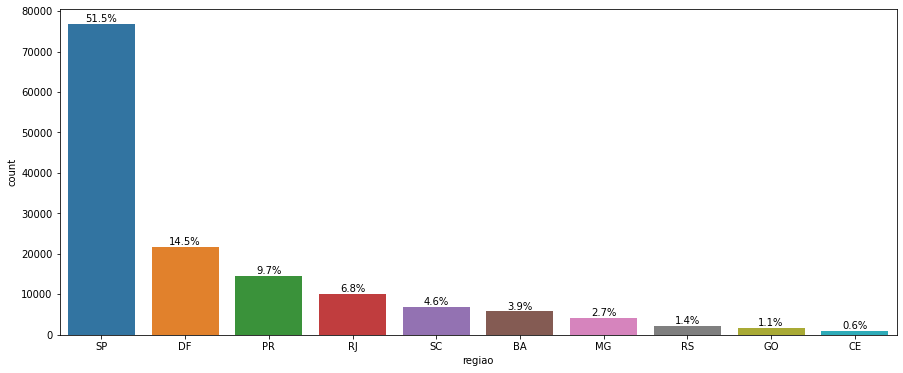

In [142]:
serie_filtrada = df["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

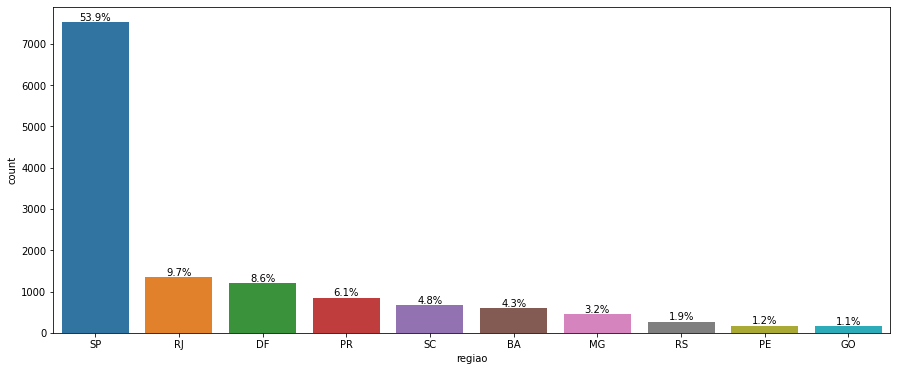

In [143]:
serie_filtrada = df[df["churn"] == 1]["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Cidade (não aparenta influenciar no churn)

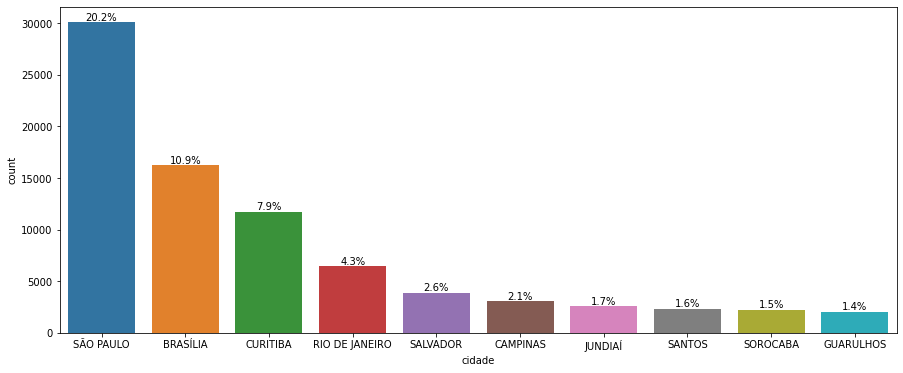

In [144]:
serie_filtrada = df["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

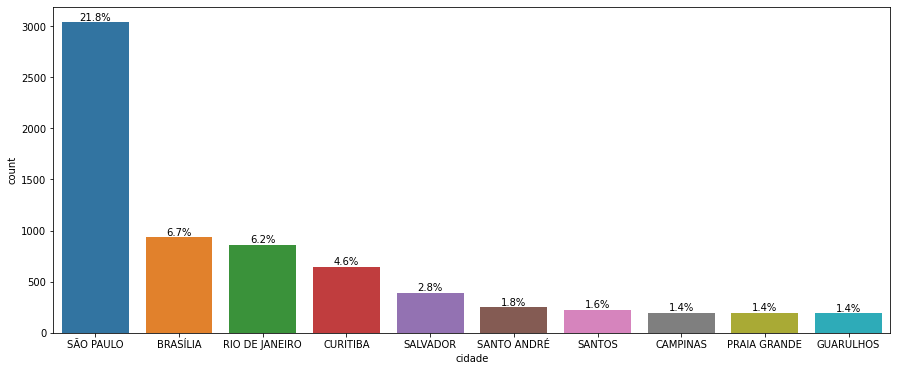

In [145]:
serie_filtrada = df[df["churn"] == 1]["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Oficina (não aparenta influenciar no churn)

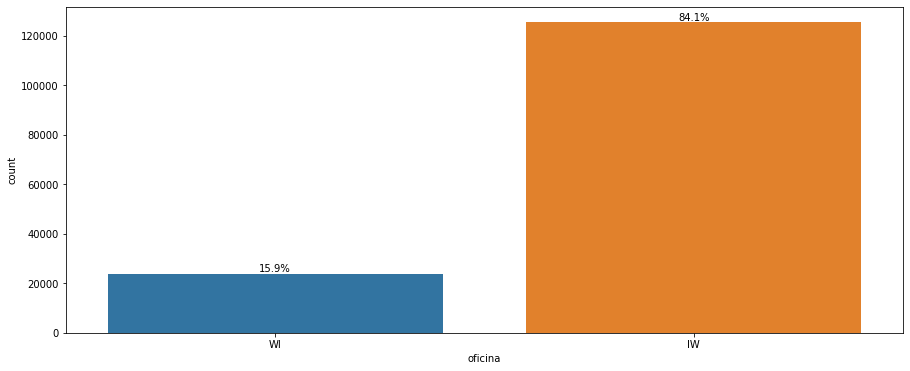

In [146]:
serie_filtrada = df["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

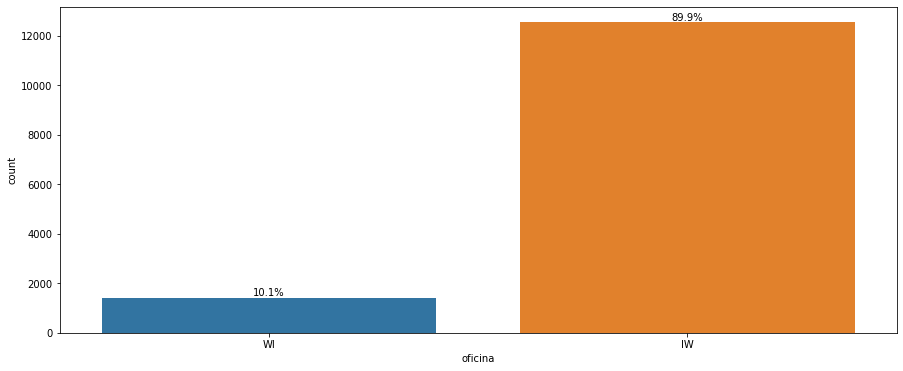

In [147]:
serie_filtrada = df[df["churn"] == 1]["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Frequência Faturamento (não aparenta influenciar no churn)

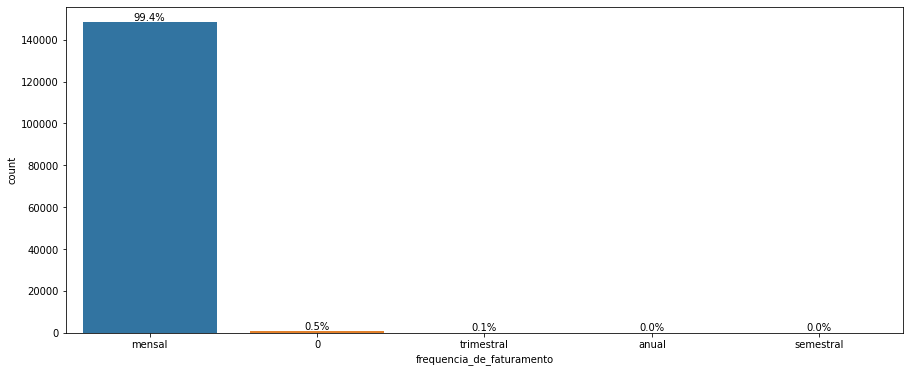

In [148]:
serie_filtrada = df["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

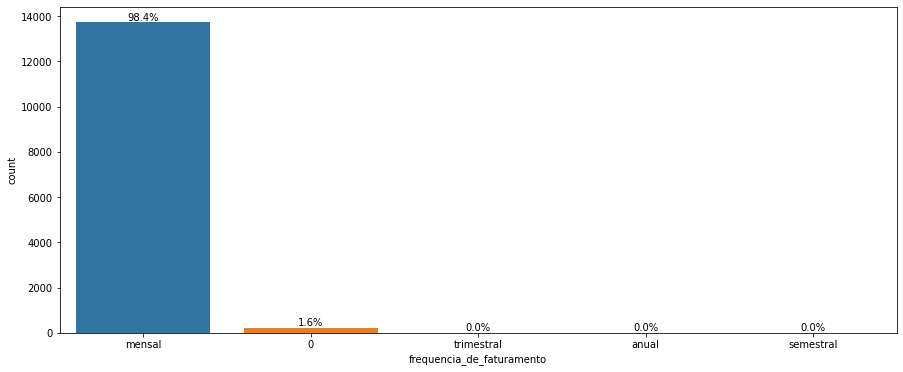

In [149]:
serie_filtrada = df[df["churn"] == 1]["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Tipo de Plano (pode influenciar no churn)

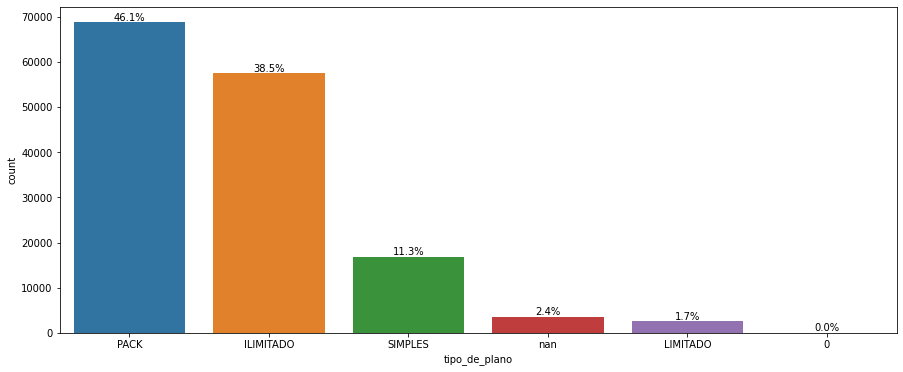

In [150]:
serie_filtrada = df["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

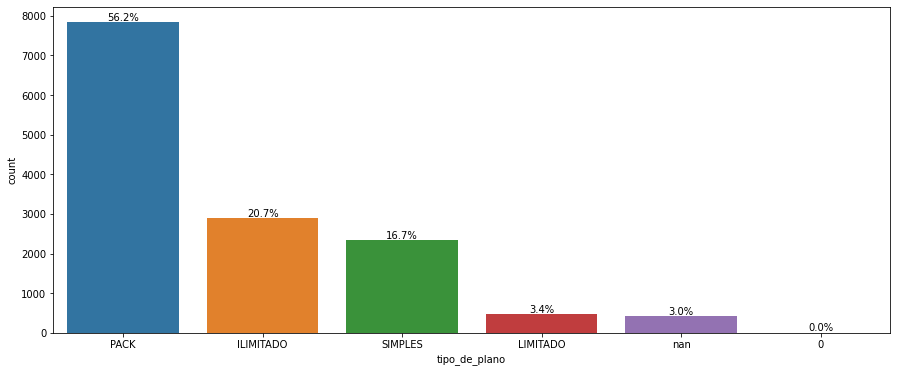

In [151]:
serie_filtrada = df[df["churn"] == 1]["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Executivo Carteira Atual (não aparenta influenciar no churn)

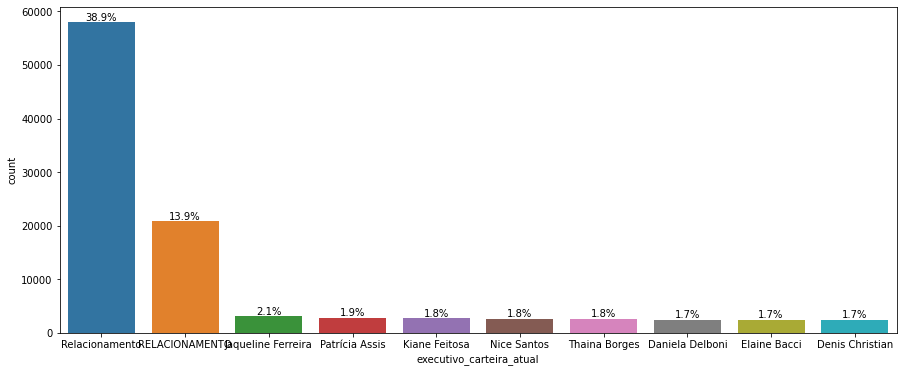

In [152]:
serie_filtrada = df["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

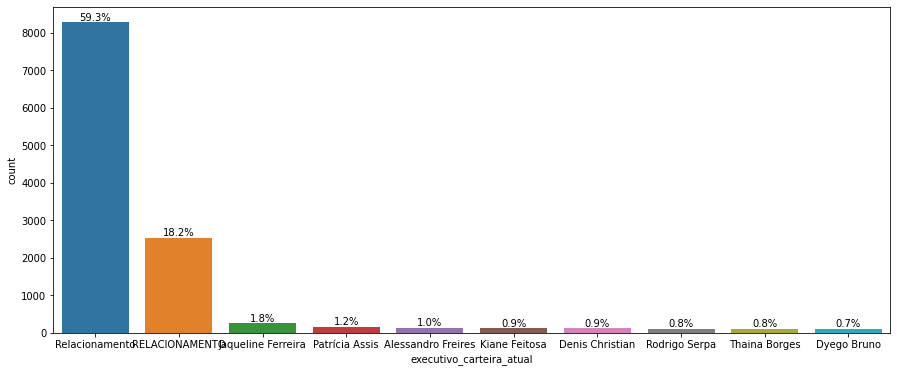

In [153]:
serie_filtrada = df[df["churn"] == 1]["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Equipe (pode influenciar no churn)

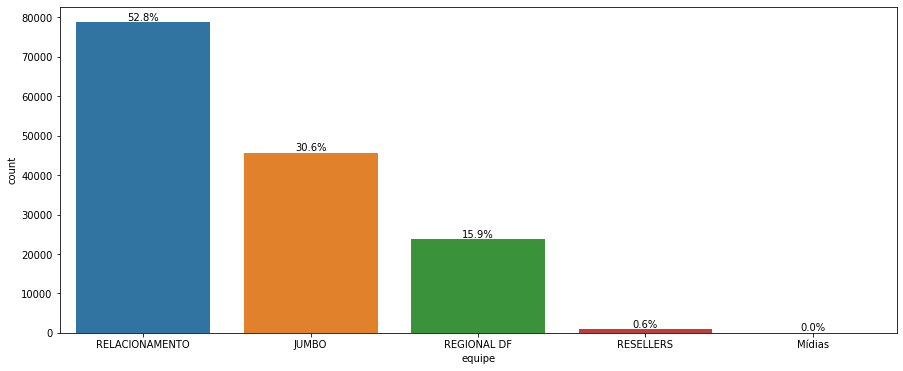

In [154]:
serie_filtrada = df["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

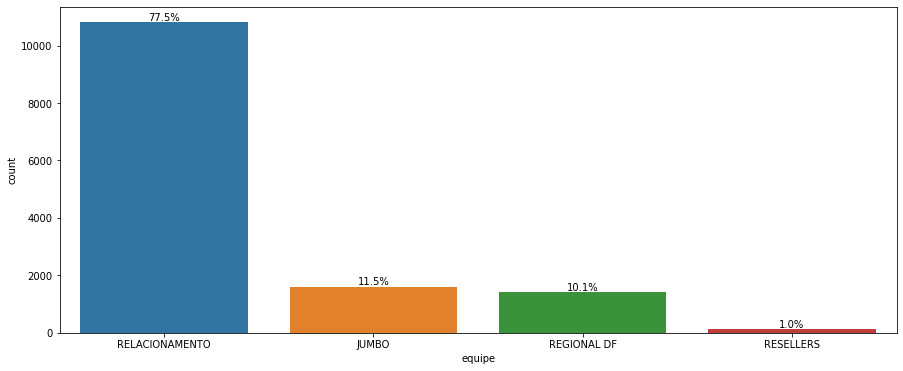

In [155]:
serie_filtrada = df[df["churn"] == 1]["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Status Final (alta correlação com churn, talvez não seja interessante manter)

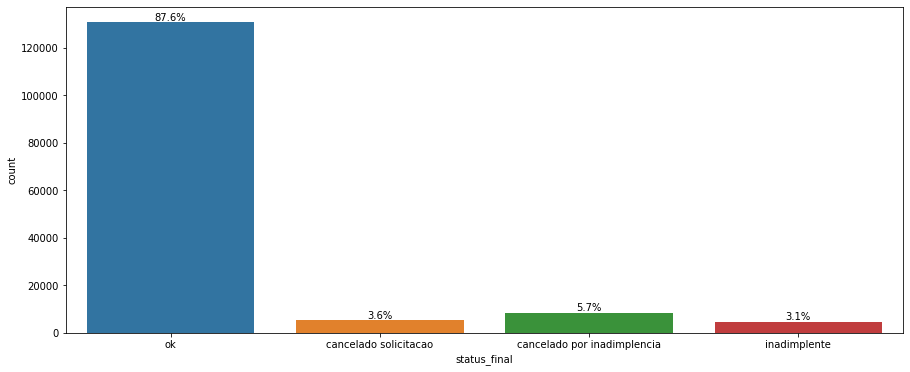

In [156]:
serie_filtrada = df["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

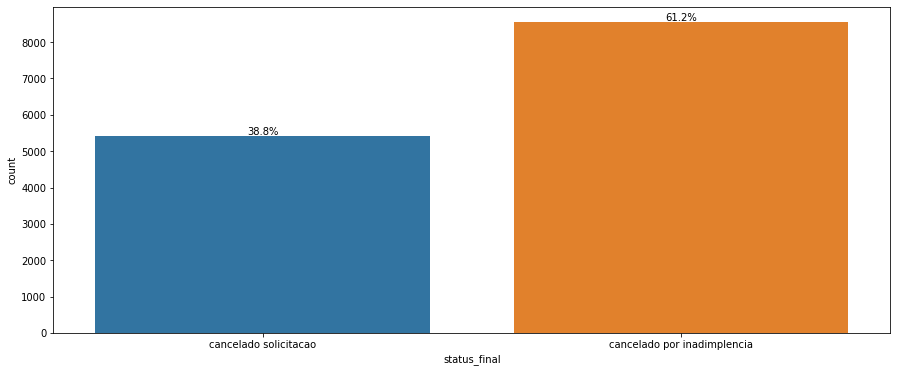

In [157]:
serie_filtrada = df[df["churn"] == 1]["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Possui Midia Ativa (pode ter influencia no churn, mas muito pouco)

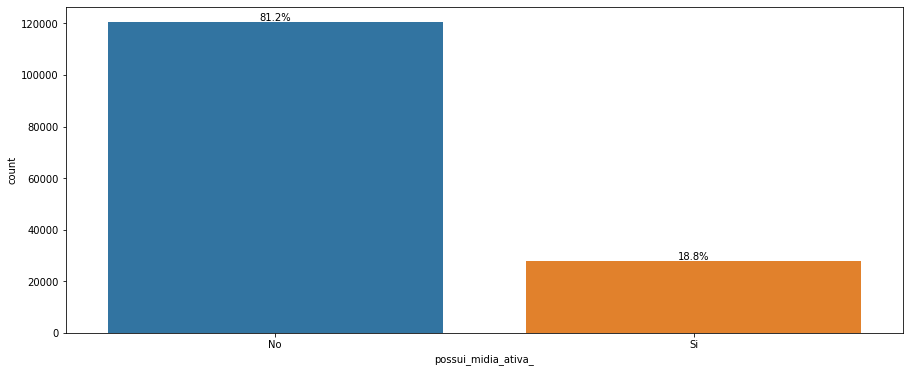

In [158]:
serie_filtrada = df["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

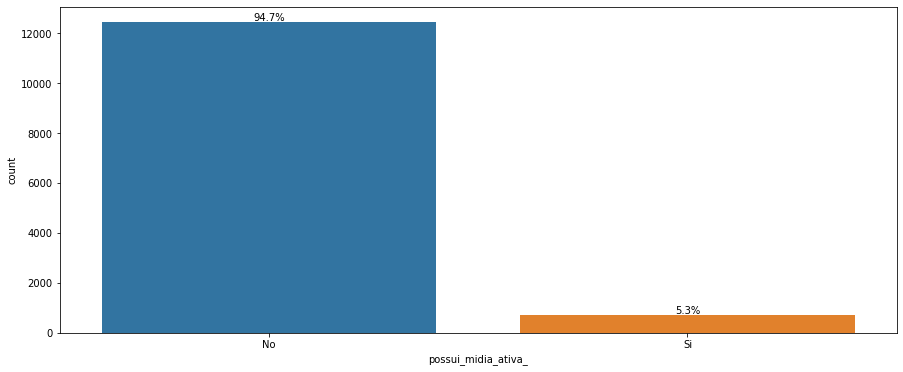

In [159]:
serie_filtrada = df[df["churn"] == 1]["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Pessoa Física Jurídica (relação forte com o churn)

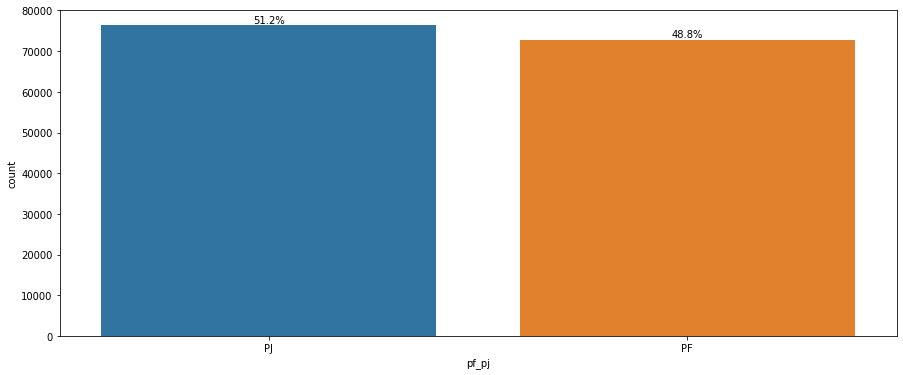

In [160]:
serie_filtrada = df["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

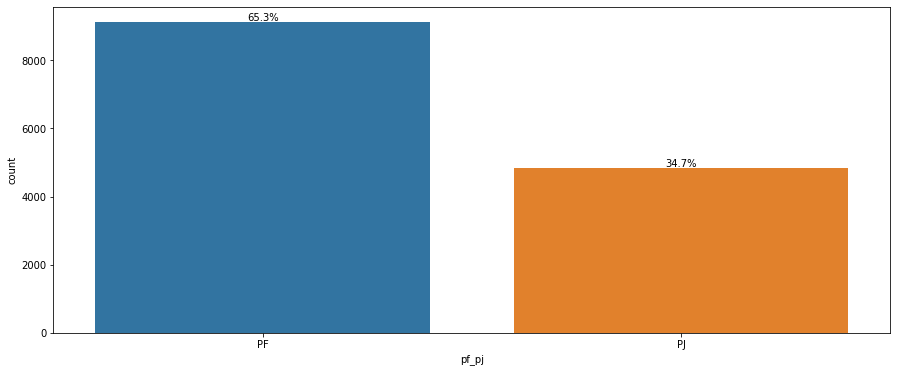

In [161]:
serie_filtrada = df[df["churn"] == 1]["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Faixa Listings (relação forte com o churn)

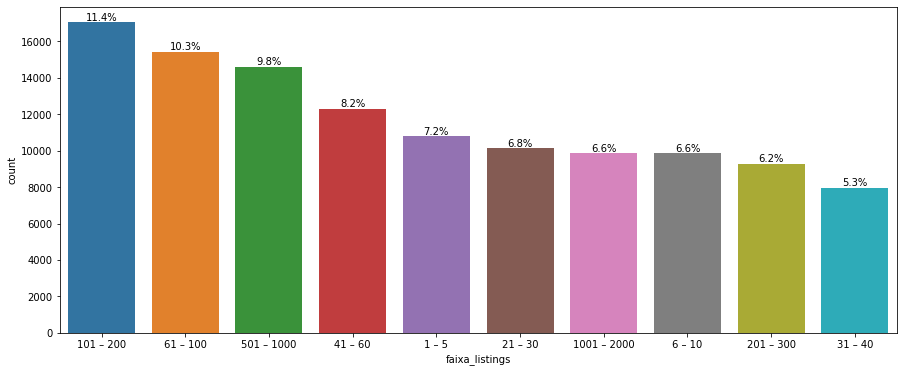

In [162]:
serie_filtrada = df["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

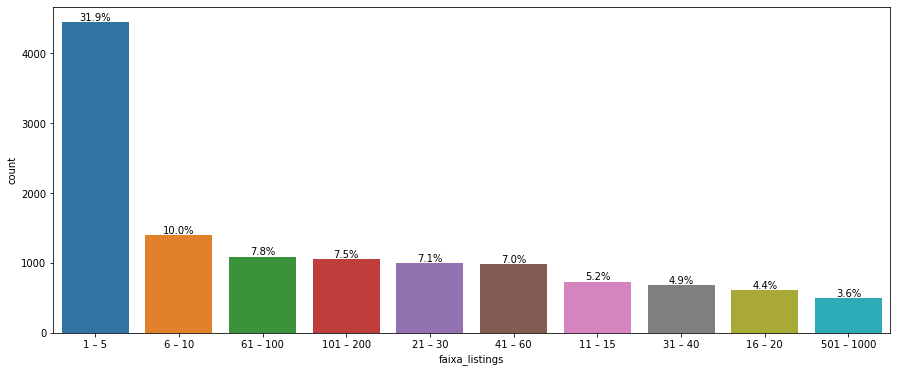

In [163]:
serie_filtrada = df[df["churn"] == 1]["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

In [164]:
def box_plot(coluna_medida, limite_inferior, limite_superior):
    f, ax = plt.subplots(figsize=(5, 4))
    sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
    plt.ylim((limite_inferior, limite_superior))
    sns.stripplot(x="churn", y=coluna_medida, data=df,
                size=1, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel=coluna_medida)
    sns.despine(trim=True, left=True)

### Análise Valor Mensal (pode influenciar no churn, mas pouco)

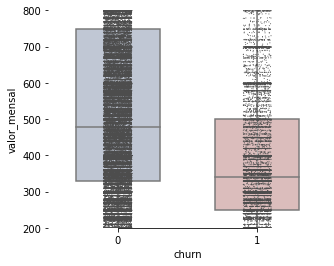

In [165]:
box_plot("valor_mensal", 200, 800)

### Análise Valor Hoje (alta correlação com churn. Talvez seja melhor remover)

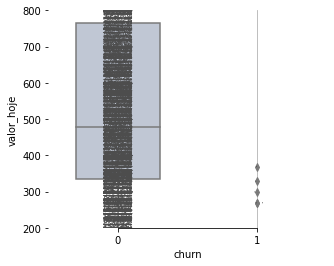

In [166]:
box_plot("valor_hoje", 200, 800)

### Análise Faturamento (Alta correlação com churn. Talvez seja melhor tirar)

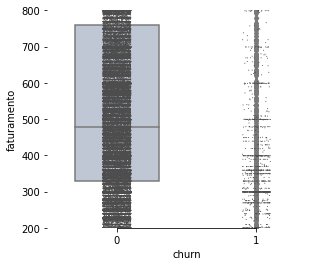

In [167]:
box_plot("faturamento", 200, 800)

### Análise Contratado Super Destaques (pode influenciar no churn)

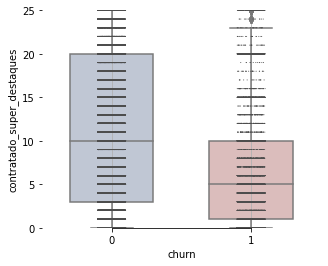

In [168]:
box_plot("contratado_super_destaques", 0, 25)

### Análise Contratado Destaques (não aparenta influenciar no churn)

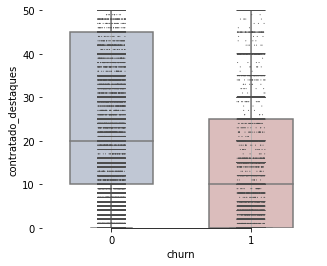

In [169]:
box_plot("contratado_destaques", 0, 50)

### Análise Contratado Ofertas Simples (Relação forte com o churn)

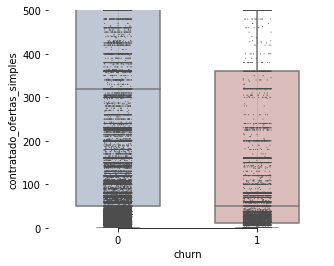

In [170]:
box_plot("contratado_ofertas_simples", 0, 500)

### Análise Utilizado Super Destaque (pode influenciar o churn)

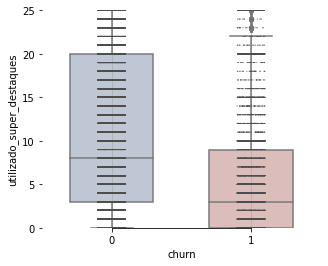

In [171]:
box_plot("utilizado_super_destaques", 0, 25)

### Análise Utilizado Destaque (pode influenciar o churn)

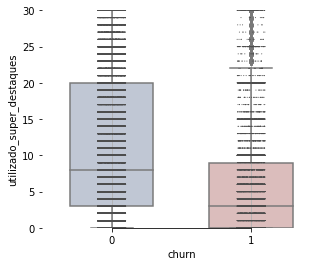

In [172]:
box_plot("utilizado_super_destaques", 0, 30)

### Análise Utilizado Ofertas Simples (Relação forte com o churn)

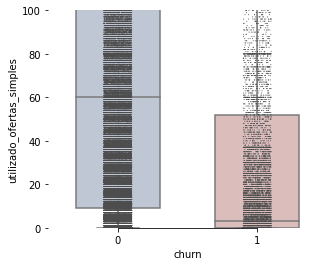

In [173]:
box_plot("utilizado_ofertas_simples", 0, 100)

### Análise Leads Form (Relação forte com o churn)

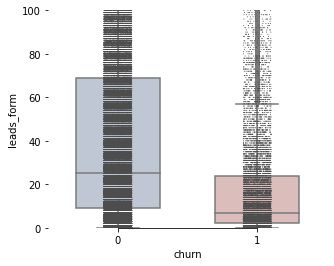

In [174]:
box_plot("leads_form", 0, 100)

### Análise Leads Ver Dato (Relação forte com o churn)

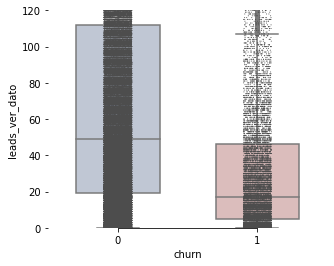

In [175]:
box_plot("leads_ver_dato", 0, 120)

### Análise Leads Total (Relação forte com o churn)

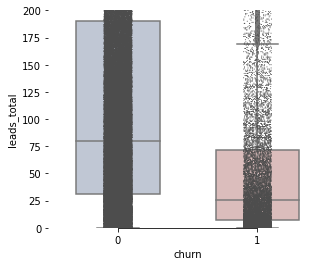

In [176]:
box_plot("leads_total", 0, 200)

### Análise Custo Por Lead Total (Alta correlação com churn. Talvez seja melhor remover)

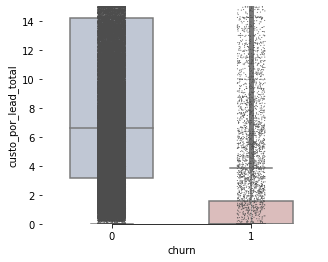

In [177]:
box_plot("custo_por_lead_total", 0, 15)

### Análise Total Contratado (Relação fortíssima com o churn)

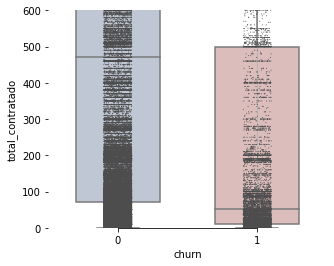

In [178]:
box_plot("total_contratado", 0, 600)

### Análise Total de Listings (Relação forte com o churn)

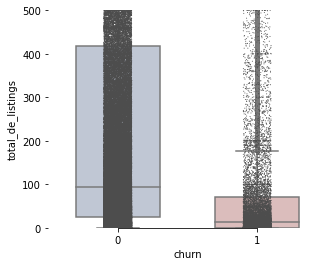

In [179]:
box_plot("total_de_listings", 0, 500)

### Análise Custo Por Listing (Alta correlação com churn. Talvez seja melhor remover)

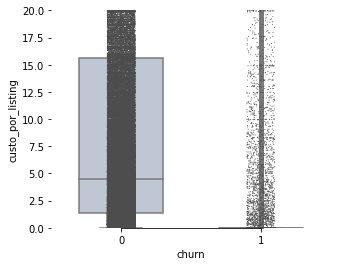

In [180]:
box_plot("custo_por_listing", 0, 20)

### Análise Total Utilizado (Relação fortíssima com o churn)

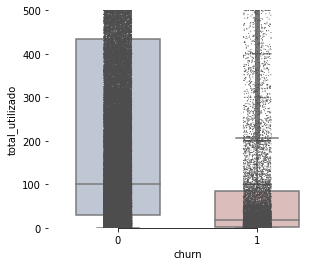

In [181]:
box_plot("total_utilizado", 0, 500)

### Quantidade Mês (Relação fortíssima com o churn)

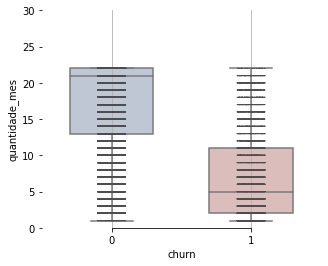

In [182]:
box_plot("quantidade_mes", 0, 30)


# Data Cleaning and Data Wrangling

### Criação de novo dataframe com somente as colunas relevantes

In [183]:
# pode influenciar tanto que talvez seja melhor remover:
# status_final, valor_hoje, faturamento, custo_por_lead_total, custo_por_listing

# pode influenciar muito:
# pf_pj, faixa_listings, contratado_ofertas_simples, utilizado_ofertas_simples,
# leads_form, leads_ver_dato, leads_total, total_contratado, total_de_listings,
# total_utilizado, quantidade_mes, status_pagamento

# pode influenciar:
# tipo_de_plano, equipe, contratado_super_destaques, utilizado_super_destaques, 
# utilizado_destaque

# pode influenciar pouco:
# possui_midia_ativa_, valor_mensal

In [184]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'utilizado_super_destaques',
       'utilizado_destaque', 'utilizado_ofertas_simples',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn', 'quantidade_mes', 'status_pagamento'],
      dtype='object')

In [185]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
         'leads_form', 'leads_ver_dato', 'total_contratado', 'total_de_listings',
         'total_utilizado', 'equipe', 'contratado_super_destaques', 'utilizado_super_destaques',
         'utilizado_destaque', 'valor_mensal', 'quantidade_mes', 'status_pagamento', 'churn']].copy()


### Plot do gráfico de correlação entre variáveis preditoras

<AxesSubplot:>

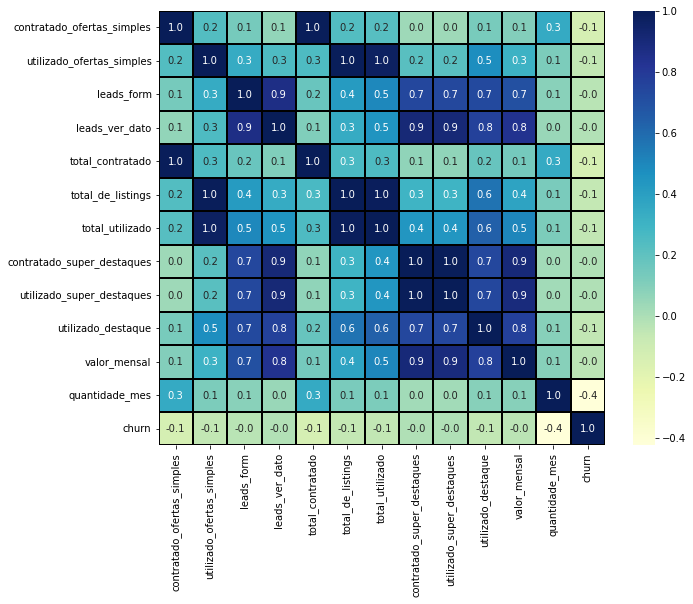

In [186]:
corr = df.corr()

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f", linecolor="black", linewidths="0.1", )

In [187]:
df = df[['pf_pj','leads_form', 'total_contratado', 'total_de_listings', 'equipe', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal', 'quantidade_mes', 'status_pagamento', 'churn']].copy()


<AxesSubplot:>

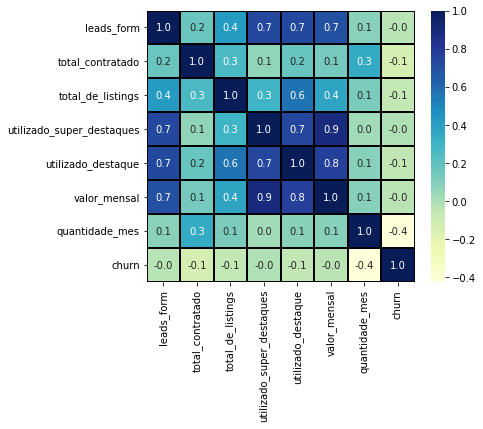

In [188]:
corr = df.corr()

plt.subplots(figsize=(6, 5))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f",
            linecolor="black", linewidths="0.1", )


# Modeling

### Tratatamento das variáveis numéricas e categóricas

In [189]:
def fnTrataDados(df_dados, dfChurn):
    df_dados.dropna(subset=['status_pagamento'], inplace=True)

    dfCategorical = pd.get_dummies(df_dados.select_dtypes(include=['object']), columns=[
        'pf_pj', 'equipe', 'status_pagamento'])

    dfNumerical = df_dados.select_dtypes(
        include=np.number)
    dfNumerical = dfNumerical.fillna(dfNumerical.median())

    for col in dfNumerical.columns:
        df_dados[col][dfNumerical[col] < 0] = 0

    dfNumerical = dfNumerical.copy()
    dfNumerical[['leads_form', 'total_contratado', 'total_de_listings', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal', 'quantidade_mes']] = RobustScaler().fit_transform(dfNumerical[['leads_form', 'total_contratado', 'total_de_listings', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal', 'quantidade_mes']])
    df_dados = pd.concat(
        [dfNumerical, dfCategorical, dfChurn], axis=1, join='inner')

    return [df_dados.drop(['churn'], axis=1), df_dados['churn']]


### Separação do dataset em treino, validação e teste

In [190]:
X = df.drop(['churn'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2


#### Tratamentos dos dados de treino, teste e validação

In [191]:
X_train, y_train = fnTrataDados(X_train, y_train)
X_val, y_val = fnTrataDados(X_val, y_val)
X_test, y_test = fnTrataDados(X_test, y_test)

#### Execução do modelo

In [192]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_val, label=y_val)

param = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'multi:softprob',
    'num_class': 3}

steps = 20  # The number of training iterations

modelXG = xgb.train(param, D_train, steps)

modelRF = RandomForestClassifier(n_jobs=-1)
modelRF.fit(X_train, y_train)

modelGB = GradientBoostingClassifier()
modelGB.fit(X_train, y_train)


GradientBoostingClassifier()

#### Resultados do modelo aplicados ao dataset de validação

In [193]:
predictXG = modelXG.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in predictXG])

f1 = round(f1_score(y_val, best_preds, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, best_preds)*100, 2)
precision = round(precision_score(y_val, best_preds)*100, 2)
recall = round(recall_score(y_val, best_preds)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["XGBoost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}


F1 Score: 67.6%
Accuracy Score: 92.84%
Precision Score: 90.11%
Recall Score: 24.89%


F1 Score: 76.05%
Accuracy Score: 93.94%
Precision Score: 85.94%
Recall Score: 40.82%


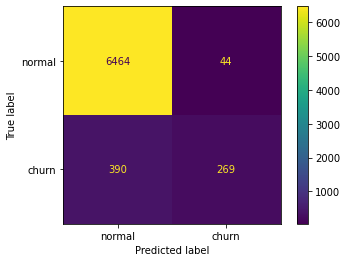

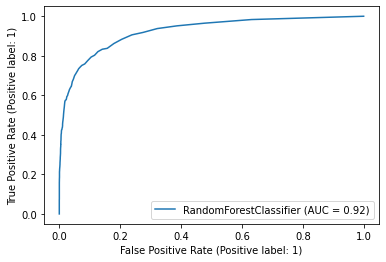

In [194]:
predictRF = modelRF.predict(X_val)

f1 = round(f1_score(y_val, predictRF, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predictRF)*100, 2)
precision = round(precision_score(y_val, predictRF)*100, 2)
recall = round(recall_score(y_val, predictRF)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["RandomForest"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelRF, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelRF, X_val, y_val)
plt.show()


F1 Score: 73.04%
Accuracy Score: 93.57%
Precision Score: 88.98%
Recall Score: 34.29%


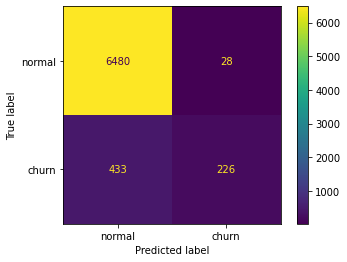

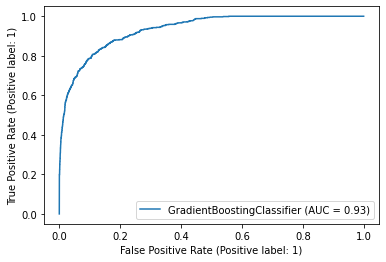

In [195]:
predictGB = modelGB.predict(X_val)

f1 = round(f1_score(y_val, predictGB, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predictGB)*100, 2)
precision = round(precision_score(y_val, predictGB)*100, 2)
recall = round(recall_score(y_val, predictGB)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelGB, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelGB, X_val, y_val)
plt.show()


In [196]:
resumo = pd.DataFrame.from_dict(metricas, orient='index')
resumo


accuracy  precision  recall     f1
XGBoost              92.84      90.11   24.89  67.60
RandomForest         93.94      85.94   40.82  76.05
GradientBoosting     93.57      88.98   34.29  73.04

### Definição do melhor modelo

In [197]:
clf = modelGB


### Tunning de hiperparâmetros dos melhores modelos

In [198]:
# parameters = {
#     "loss": ["deviance"],
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth": [3, 5, 8],
#     "max_features": ["log2", "sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample": [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "n_estimators": [10, 100, 250, 500]
# }

# bayes_search = BayesSearchCV(modelGB, search_spaces=parameters, cv=5, n_jobs=-1, verbose=10)
# bayes_search.fit(X_train, y_train)


In [199]:
# bayes_search.best_estimator_
# GradientBoostingClassifier(learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9)

# Resultado:
# GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features='log2',
#                            min_samples_leaf=0.1,
#                            min_samples_split=0.28181818181818186,
#                            n_estimators=500, subsample=0.95)


F1 Score: 79.71%
Accuracy Score: 94.56%
Precision Score: 85.68%
Recall Score: 49.01%


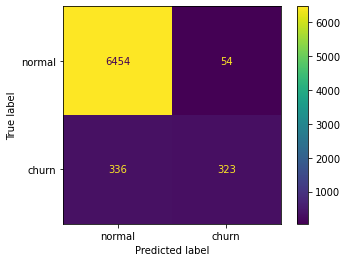

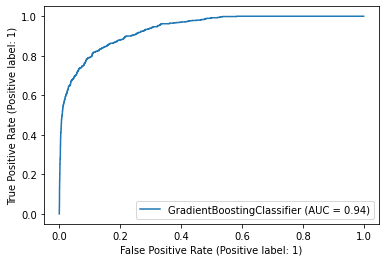

In [200]:
clf = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features='log2',
                           min_samples_leaf=0.1,
                           min_samples_split=0.28181818181818186,
                           n_estimators=500, subsample=0.95)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

f1 = round(f1_score(y_val, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, y_pred)*100, 2)
precision = round(precision_score(y_val, y_pred)*100, 2)
recall = round(recall_score(y_val, y_pred)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(clf, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
                      
plt.grid(False)
plt.show()

plot_roc_curve(clf, X_val, y_val)
plt.show()


In [201]:
joblib.dump(clf, 'GB_churn_imovel_web.pkl')


['GB_churn_imovel_web.pkl']

### Avaliação da performance do modelo com os dados de teste


In [202]:
y_pred = clf.predict(X_test)

data_set_valid = X_test.reset_index(drop=True)
y_real = pd.Series(y_test).reset_index(drop=True)
y_predito = pd.Series(y_pred, name='churn_predito').reset_index(drop=True)

df_teste = pd.concat([data_set_valid, y_real, y_predito], axis=1)

Quantidade total: 7074
Preditos Corretamente: 6669
Preditos Icorretamente: 405


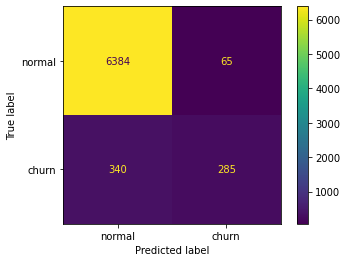

In [203]:
print('Quantidade total: {}'.format(len(df_teste)))
print('Preditos Corretamente: {}'.format(len(df_teste[df_teste['churn'] == df_teste['churn_predito']])))
print('Preditos Icorretamente: {}'.format(len(df_teste[df_teste['churn'] != df_teste['churn_predito']])))


plot_confusion_matrix(clf, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")


### Interpretabilidade individual do resultado dos registros classificados pelo modelo

In [204]:
def predict_explainer(df_fil):
    ''' Apresenta o explain das probabilidades que definiram o registro como "churn" ou não '''
    index_registro_visualizacao = df_fil.sample().index[0]

    print('Quantidade de registros preditos nessa categoria: {}'.format(len(df_fil)))
    print()
    print('-' * 5 + ' Churn Real / Churn Predito ' + '-' * 5)
    print()
    print(df_teste[['churn', 'churn_predito']
                   ].iloc[index_registro_visualizacao])
    print()
    print('-' * 5 + ' Probabilidade ' + '-' * 5)

    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   class_names=[
                                                       "Não Churn", "Churn"],
                                                   mode='classification')

    exp = explainer.explain_instance(X_val.iloc[index_registro_visualizacao],
                                     clf.predict_proba,
                                     num_features=10,
                                     top_labels=1)

    return exp.show_in_notebook(show_table=True, show_all=False)


In [205]:
# Reseta os índices para que possamos procurar os registros

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


#### Explain aleatório dos "Churns" considerados "Churn" pelo modelo

In [206]:
df_fil = df_teste[(df_teste['churn'] == df_teste['churn_predito']) & (df_teste['churn'] == 1)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 285

----- Churn Real / Churn Predito -----

churn            1
churn_predito    1
Name: 1643, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Não Churns" considerados "Não Churn" pelo modelo

In [207]:
df_fil = df_teste[(df_teste['churn'] == df_teste['churn_predito']) & (df_teste['churn'] == 0)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 6384

----- Churn Real / Churn Predito -----

churn            0
churn_predito    0
Name: 3233, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Churns" considerados "Não Churn"

In [208]:
df_fil = df_teste[(df_teste['churn'] != df_teste['churn_predito']) & (df_teste['churn'] == 1)]
predict_explainer(df_fil)

Quantidade de registros preditos nessa categoria: 340

----- Churn Real / Churn Predito -----

churn            1
churn_predito    0
Name: 3706, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Não Churn" considerados "Churn"

In [209]:
df_fil = df_teste[(df_teste['churn'] != df_teste['churn_predito']) & (df_teste['churn'] == 0)]
predict_explainer(df_fil)

Quantidade de registros preditos nessa categoria: 65

----- Churn Real / Churn Predito -----

churn            0
churn_predito    1
Name: 6321, dtype: int64

----- Probabilidade -----
